# Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}{nnodes}.csv', index_col= 'date', parse_dates=True)# Analysis of optimal scenarios agaisnt other scenarios

In [10]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'microechopc'
outdir = '2021-01-14_nanoechopc/'


n_int_steps = 5
nnodes = 107  # nodes
ndays = 15

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [2]:
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(29)}

In [3]:
scenarios.keys()

dict_keys(['U-r1-t125000', 'L-r1-t125000', 'U-r2-t125000', 'L-r2-t125000', 'U-r15-t125000', 'L-r15-t125000', 'U-r1-t250000', 'L-r1-t250000', 'U-r2-t250000', 'L-r2-t250000', 'U-r15-t250000', 'L-r15-t250000', 'U-r1-t479700', 'L-r1-t479700', 'U-r2-t479700', 'L-r2-t479700', 'U-r15-t479700', 'L-r15-t479700', 'U-r1-t1000000', 'L-r1-t1000000', 'U-r2-t1000000', 'L-r2-t1000000', 'U-r15-t1000000', 'L-r15-t1000000', 'U-r1-t2000000', 'L-r1-t2000000', 'U-r2-t2000000', 'L-r2-t2000000', 'U-r15-t2000000'])

In [4]:
# Choose a subset of scenarios:
pick = 'U-r15'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}
print(len(scenarios))

5


In [6]:
no_vacc = {}
no_vacc['L'] = pd.read_csv(f'2021-01-14_nanoechopc/-L-r1-t1000000-int-107_15-nc.csv', index_col= 'date', parse_dates=True)
no_vacc['U'] = pd.read_csv(f'2021-01-14_nanoechopc/-U-r1-t1000000-int-107_15-nc.csv', index_col= 'date', parse_dates=True)

In [101]:
max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenarios['U-r1-t125000'])

In [102]:
vacc_total

array([ 17857.14285714,  35714.28571429,  53571.42857143,  71428.57142857,
        89285.71428571, 107142.85714286, 125000.        , 142857.14285714,
       160714.28571429, 178571.42857143, 196428.57142857, 214285.71428571,
       232142.85714286, 250000.        , 267857.14285714, 285714.28571429,
       303571.42857143, 321428.57142857, 339285.71428571, 357142.85714286,
       375000.        , 392857.14285714, 410714.28571429, 428571.42857143,
       446428.57142857, 464285.71428571, 482142.85714286, 500000.        ,
       517857.14285714, 535714.28571429, 553571.42857143, 571428.57142857,
       589285.71428571, 607142.85714286, 625000.        , 642857.14285714,
       660714.28571429, 678571.42857143, 696428.57142857, 714285.71428571,
       732142.85714286, 750000.        , 767857.14285714, 785714.28571429])

In [12]:
scenarios_opt = {}
## Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    fname = f'{outdir}{file_prefix}-{scenario_name}-opt-{nnodes}_{ndays}.csv'
    try:
        md = pd.read_csv(fname, index_col= 'date', parse_dates=True)
        print(f'YES {fname}')
        control_initial = np.zeros((M, N))
        allocated_total = 0
        unvac_nd = np.copy(setup.pop_node)

        for nodename in md.place.unique():
            mdn = md[(md['place'] == nodename) & (md['comp'] == 'vacc')]
            for date in mdn.index[:-2]:
                nd = setup.ind2name.index(nodename)
                k = list(setup.model_days).index(date)
                control_initial[nd, k] = mdn.loc[date].value
                allocated_total += mdn.loc[date].value
                unvac_nd[nd] -= mdn.loc[date].value

        p.apply_epicourse(setup, scenario['beta_mult'])

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'{outdir}{file_prefix}{scenario_name}-opi{nnodes}_{ndays}',
                                                                          n_rk4_steps=n_int_steps)
        results.set_index('date', drop=True, inplace=True)
        scenarios_opt[scenario_name] = scenario
        
    except FileNotFoundError:
        print(f'NOT {fname}')

YES 2021-01-14_nanoechopc/microechopc-U-r15-t125000-opt-107_15.csv


 29%|██▊       | 4/14 [00:00<00:00, 16.48it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t125000-opi107_15


100%|██████████| 14/14 [00:00<00:00, 16.47it/s]


YES 2021-01-14_nanoechopc/microechopc-U-r15-t250000-opt-107_15.csv


 14%|█▍        | 2/14 [00:00<00:00, 13.82it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t250000-opi107_15


100%|██████████| 14/14 [00:01<00:00, 12.52it/s]


YES 2021-01-14_nanoechopc/microechopc-U-r15-t479700-opt-107_15.csv


 14%|█▍        | 2/14 [00:00<00:01, 10.88it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t479700-opi107_15


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


YES 2021-01-14_nanoechopc/microechopc-U-r15-t1000000-opt-107_15.csv


 14%|█▍        | 2/14 [00:00<00:00, 15.78it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t1000000-opi107_15


100%|██████████| 14/14 [00:00<00:00, 15.79it/s]


YES 2021-01-14_nanoechopc/microechopc-U-r15-t2000000-opt-107_15.csv


 14%|█▍        | 2/14 [00:00<00:00, 15.50it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t2000000-opi107_15


100%|██████████| 14/14 [00:01<00:00, 12.79it/s]


In [13]:
# Generate alternatives:
# BY INCIDENCE: 
for scenario_name, scenario in scenarios_opt.items():
    nv = no_vacc[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    print(scenario_name)
    control_initial = np.zeros((M, N))
    max_vacc_rate = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    vacc_total = np.zeros(N)

    stockpile = 0
    for k in range(N):
        vacc_total[k] = scenario['newdoseperday']
        stockpile += vacc_total[k]
        for nd in range(M):
            pop_nd = setup.pop_node[nd]
            max_vacc_rate[nd, k] = eval(scenario['rate_fomula'])
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, max_vacc_rate[nd, k], unvac_nd[nd] - 100)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
                
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-inc{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

# BY POPULATION 
for scenario_name, scenario in scenarios_opt.items():
    control_initial = np.zeros((M, N))
    max_vacc_rate = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    vacc_total = np.zeros(N)

    stockpile = 0
    for k in range(N):
        vacc_total[k] = scenario['newdoseperday']
        stockpile += vacc_total[k]
        for nd in range(M):
            pop_nd = setup.pop_node[nd]
            max_vacc_rate[nd, k] = eval(scenario['rate_fomula'])
            to_allocate = stockpile * pop_nd / setup.pop_node.sum()
            to_allocate = min(to_allocate, max_vacc_rate[nd, k], unvac_nd[nd] - 100)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-pop{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

U-r15-t125000


  7%|▋         | 1/14 [00:00<00:01,  9.41it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t125000-inc107_15


100%|██████████| 14/14 [00:01<00:00,  9.56it/s]


U-r15-t250000
===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t250000-inc107_15

 14%|█▍        | 2/14 [00:00<00:00, 15.39it/s]

100%|██████████| 14/14 [00:00<00:00, 15.34it/s]


U-r15-t479700


 14%|█▍        | 2/14 [00:00<00:00, 14.31it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t479700-inc107_15


  0%|          | 0/14 [00:00<?, ?it/s]

U-r15-t1000000
===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t1000000-inc107_15


100%|██████████| 14/14 [00:00<00:00, 14.55it/s]


U-r15-t2000000


 14%|█▍        | 2/14 [00:00<00:01, 10.78it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t2000000-inc107_15


 14%|█▍        | 2/14 [00:00<00:00, 12.24it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t125000-pop107_15


 14%|█▍        | 2/14 [00:00<00:01, 11.40it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t250000-pop107_15


 14%|█▍        | 2/14 [00:00<00:00, 16.56it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t479700-pop107_15


 14%|█▍        | 2/14 [00:00<00:00, 14.98it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t1000000-pop107_15


 14%|█▍        | 2/14 [00:00<00:00, 14.83it/s]

===> Integrating for 2021-01-14_nanoechopc/microechopcU-r15-t2000000-pop107_15


100%|██████████| 14/14 [00:00<00:00, 15.18it/s]


In [25]:
scenario_name.split('-')

['U', 'r1', 't2000000']

In [14]:
scn_results = pd.DataFrame(columns=['newdoseperweek', 'method', 'infected'])
methods = ['opi', 'inc', 'pop'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios_opt.items():
        max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
        md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}{nnodes}_{ndays}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
        doses = md[md['comp']=='vacc']['value'].sum()
        nv = no_vacc[scenario_name.split('-')[0]]
        baseline_infected = nv[(nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])) & (nv.index == str(setup.end_date))]['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'newdoseperweek':[int(np.diff(vacc_total)[0:7].sum())],
                                                                      'method': [met],
                                                                      'infected':[infected],
                                                                       'doses': [doses],
                                                                       'scenario-beta': [scenario_name.split('-')[0]],
                                                                       'scenario-rate': [scenario_name.split('-')[1]],
                                                                       'scenario-tot': [scenario_name.split('-')[2]],
                                                                       'averted': baseline_infected - infected
                                                                     })])                      
   
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

In [15]:
#scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('opi', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)

In [95]:
scn_results[scn_results['scenario-rate']=='r15']

,newdoseperweek,method,infected,doses,scenario-beta,scenario-rate,scenario-tot,averted,avertedpervacc
0,125000,Optimal,4.470706e+06,1.117460e+06,L,r15,t125000,45294.541650,0.040533
0,250000,Optimal,5.774816e+06,2.234921e+06,U,r15,t250000,338560.786166,0.151487
0,250000,Optimal,4.450317e+06,2.234921e+06,L,r15,t250000,65683.651009,0.029390
0,2000000,Optimal,5.285452e+06,1.664603e+07,U,r15,t2000000,827925.057168,0.049737
0,125000,Incidence,4.506508e+06,7.933787e+05,L,r15,t125000,9492.711901,0.011965
0,250000,Incidence,6.002332e+06,1.586699e+06,U,r15,t250000,111044.575507,0.069985
0,250000,Incidence,4.497352e+06,1.586757e+06,L,r15,t250000,18648.743154,0.011753
0,2000000,Incidence,5.456308e+06,1.267918e+07,U,r15,t2000000,657069.231192,0.051823
0,125000,Population,4.508006e+06,7.933495e+05,L,r15,t125000,7995.194073,0.010078
0,250000,Population,6.032555e+06,1.586699e+06,U,r15,t250000,80822.379842,0.050937


In [62]:
#scn_results['total_vaccB'] = [f"{i/1e6:.0f}M" for i in scn_results['total_vacc']]

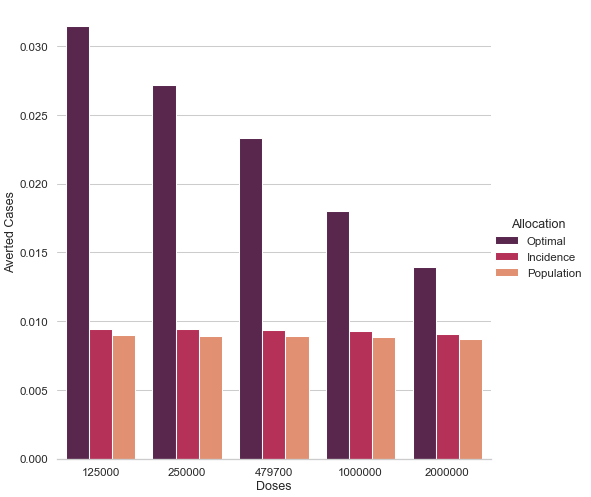

In [18]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=scn_results,#[(scn_results['scenario-rate']=='r2') & (scn_results['scenario-beta']=='U')],
    kind="bar",
    x="newdoseperweek",
    y="avertedpervacc", 
    #y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Doses", "Averted Cases")
g.legend.set_title("Allocation")
#g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

In [44]:
[f"{str(i/1e6)}M" for i in np.sort(scn_results['total_vacc'].unique())]

['2.0M', '5.0M', '10.0M', '15.0M']

In [32]:
g = sns.lineplot(
    data=scn_results, 
    x="total_vacc", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

ValueError: Could not interpret value `total_vacc` for parameter `x`

In [ ]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results, kind="bar",
    x="method", 
    #y="avertedpervacc", 
    #x='total_vacc',
    y="averted",
    hue="method",
    col="total_vaccB",
    palette="viridis",
    #alpha=.9, 
    height=5,
    aspect = .5,
    #width = 10
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Strategy", "Averted Cases")
#g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])
(g.set_axis_labels("", "Averted Cases")
#.set_xticklabels(["Men", "Women", "Children"])
.set_titles("{col_name}")
#.set(ylim=(0, 1))
.despine(left=True))
g.set_xticklabels(rotation=-90)

In [ ]:
g = sns.catplot(
    data=scn_results, kind="point",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.set_axis_labels("", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])